In [43]:
!pip install scanpy anndata umap-learn keras-tuner tensorflow scikit-learn matplotlib seaborn pandas


import scanpy as sc
import anndata
from anndata import read_h5ad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In this version, I tried normalizing all the data bore autoencoding it.
Problems arise with future use because we cannot give it new data that was not normalized together with the original healthy data it was trained on.

In [44]:
# Parameters
PCA_components = 80

In [45]:
# load the data
train_data = anndata.read_h5ad("all_data_10percent.h5ad")

In [46]:
# Normalizing all the data
sc.pp.normalize_total(train_data, target_sum=1e4)
sc.pp.log1p(train_data)

pca = PCA(n_components=PCA_components)

train_data.obsm["X_pca"] = pca.fit_transform(train_data.X)
all_data_normalized = train_data.obsm["X_pca"]

### --- Healthy cells --- ###
healthy_cells = all_data_normalized[train_data.obs["disease"] == "normal"]
healthy = healthy_cells.copy()

# Train/test split
X_train, X_healthy_test = train_test_split(healthy, test_size=0.6, random_state=42)


In [47]:
import keras_tuner as kt

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def build_autoencoder(hp):
    input_dim = X_train.shape[1]
    input_layer = layers.Input(shape=(input_dim,))
    x = input_layer

    # Optional: Tune dropout rate
    #dropout_rate = hp.Float("dropout_rate", 0.0, 0.5, step=0.1)

    # --- Encoder ---
    for i in range(hp.Int("encoder_layers", 1, 10)):
        x = layers.Dense(
            units=hp.Int(f"encoder_units_{i}", min_value=10, max_value=500, step=10),
            activation='relu'
        )(x)
        #x = layers.Dropout(rate=dropout_rate)(x)

    # --- Bottleneck ---
    latent = layers.Dense(
        hp.Int("bottleneck_dim", min_value=10, max_value=500, step=10),
        activation='relu',
        name='bottleneck'
      )(x)
    x = latent

    # --- Decoder ---
    for i in range(hp.Int("decoder_layers", 1, 10)):
        x = layers.Dense(
            units=hp.Int(f"decoder_units_{i}", min_value=10, max_value=500, step=10),
            activation='relu'
        )(x)
        #x = layers.Dropout(rate=dropout_rate)(x)

    output_layer = layers.Dense(input_dim, activation='linear')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-3, 1e-2, 1e-1])
        ),
        loss=MeanAbsoluteError()
    )

    return model


# Use BayesianOptimization
tuner = kt.BayesianOptimization(
    build_autoencoder,
    objective='val_loss',
    max_trials=100,
    overwrite=True
)


# Run search
tuner.search(
    X_train, X_train,
    validation_split=0.25,
    epochs=200,
    batch_size=64,
    callbacks=[early_stop]
)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

#Print best hyper parameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

for param, value in best_hp.values.items():
    print(f"{param}: {value}")

Trial 100 Complete [00h 00m 39s]
val_loss: 0.2511275112628937

Best val_loss So Far: 0.1913420706987381
Total elapsed time: 01h 56m 00s
encoder_layers: 1
encoder_units_0: 500
bottleneck_dim: 340
decoder_layers: 1
decoder_units_0: 210
learning_rate: 0.001
encoder_units_1: 420
encoder_units_2: 120
decoder_units_1: 240
decoder_units_2: 210
decoder_units_3: 500
decoder_units_4: 370
encoder_units_3: 230
encoder_units_4: 500
encoder_units_5: 500
encoder_units_6: 240
encoder_units_7: 390
encoder_units_8: 10
encoder_units_9: 10
decoder_units_5: 300
decoder_units_6: 170
decoder_units_7: 500
decoder_units_8: 300
decoder_units_9: 260


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [48]:
# Save model
best_model.save("best_autoencoder_model.keras")

In [49]:
from tensorflow import keras

loaded_model = keras.models.load_model("best_autoencoder_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [50]:
#best_model.summary()
loaded_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │        40,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 340)            │       170,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 210)            │        71,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │        16,880 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 897,992 (3.43 MB)

 Trainable params: 299,330 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 598,662 (2.28 MB)

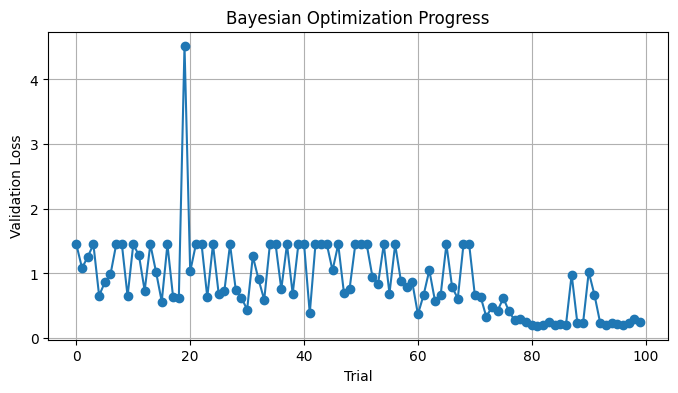

In [51]:
# Extract trial results
#trials = tuner.oracle.get_best_trials(num_trials=100)  # or all available
trials = list(tuner.oracle.trials.values())
results = []

for trial in trials:
    record = trial.hyperparameters.values.copy()
    record['val_loss'] = trial.score
    results.append(record)

import pandas as pd
df_trials = pd.DataFrame(results)

plt.figure(figsize=(8, 4))
plt.plot(df_trials['val_loss'], marker='o')
plt.xlabel("Trial")
plt.ylabel("Validation Loss")
plt.title("Bayesian Optimization Progress")
plt.grid(True)
plt.show()

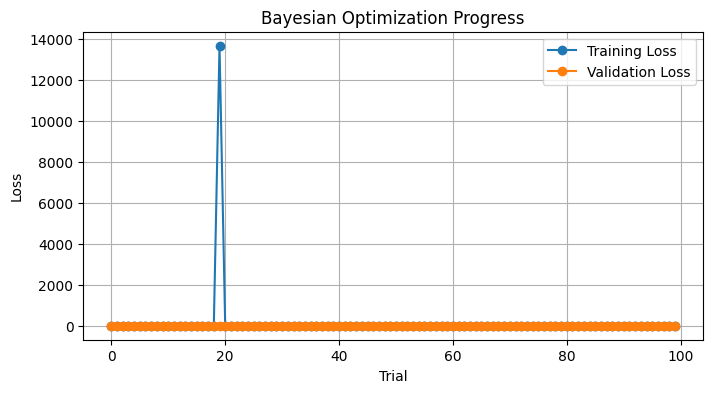

In [52]:
# Extract trial results
trials = list(tuner.oracle.trials.values())
results = []

for trial in trials:
    record = trial.hyperparameters.values.copy()

    # Try to get full training + validation loss history
    train_loss_hist = trial.metrics.get_history('loss')
    val_loss_hist = trial.metrics.get_history('val_loss')

    # Get final loss value (last epoch of this trial)
    record['val_loss'] = val_loss_hist[-1].value[0] if val_loss_hist else None
    record['loss'] = train_loss_hist[-1].value[0] if train_loss_hist else None

    results.append(record)

df_trials = pd.DataFrame(results)

# === Plot both losses ===
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(df_trials['loss'], marker='o', label='Training Loss')
plt.plot(df_trials['val_loss'], marker='o', label='Validation Loss')
plt.xlabel("Trial")
plt.ylabel("Loss")
plt.title("Bayesian Optimization Progress")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
import scanpy as sc

# import new data
test_data = anndata.read_h5ad("all_data_10percent_test.h5ad")
# Normalizing the new data
sc.pp.normalize_total(test_data, target_sum=1e4)
sc.pp.log1p(test_data)
# Apply PCA to the new data
test_data.obsm["X_pca"] = pca.transform(test_data.X)
test_data_normalized = test_data.obsm["X_pca"]

In [ ]:
X_test = test_data_normalized
#X_pred = best_model.predict(X_test)
X_pred = loaded_model.predict(X_test)

errors = np.mean((X_test - X_pred) ** 2, axis=1)
print(X_test.shape, X_pred.shape, errors.shape)

# Add to AnnData for plotting
test_data.obs["reconstruction_error"] = errors

In [ ]:
from sklearn.metrics import roc_curve, auc as sklearn_auc

# Prepare data
scores = test_data.obs["reconstruction_error"]
labels = test_data.obs["disease"]
unique_diseases = sorted(labels.unique())  # sorted ensures consistent order
palette = sns.color_palette("tab10", len(unique_diseases))
color_map = dict(zip(unique_diseases, palette))  # disease → color

# Define diseases to compare against normal
disease_classes = [d for d in unique_diseases if d != "normal"][:4]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Histogram with consistent colors ---
sns.histplot(data=test_data.obs, x="reconstruction_error", hue="disease",
             palette=color_map, bins=100, element="step", stat="density", common_norm=False, ax=axes[0])
axes[0].set_title("Reconstruction Error Histogram")
axes[0].set_xlabel("Reconstruction Error")
axes[0].set_ylabel("Density")

# --- ROC curves: each disease vs normal, using matching colors ---
for disease in disease_classes:
    mask = (labels == "normal") | (labels == disease)
    binary_labels = (labels[mask] == disease).astype(int)
    binary_scores = scores[mask]

    fpr, tpr, thresholds = roc_curve(binary_labels, binary_scores)
    roc_auc = sklearn_auc(fpr, tpr)

    # Optimal threshold (Youden’s J)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]

    # Plot ROC
    color = color_map[disease]
    axes[1].plot(fpr, tpr, label=f"{disease} (AUC = {roc_auc:.2f})", color=color)
    axes[1].plot(fpr[best_idx], tpr[best_idx], 'o', color=color, markersize=6)
    axes[1].annotate(f"{best_threshold:.3f}", (fpr[best_idx], tpr[best_idx]),
                     textcoords="offset points", xytext=(5, -10), ha='left', fontsize=8)

# Random classifier line
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.6)

axes[1].set_title("ROC Curves: Each Disease vs Normal")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Model

# Get the bottleneck layer directly by name
bottleneck_layer = best_model.get_layer(name='bottleneck')
encoder = Model(inputs=best_model.input, outputs=bottleneck_layer.output)

In [ ]:
# === 1. Build encoder model from bottleneck layer ===
bottleneck_layer = best_model.get_layer(name="bottleneck")
encoder = Model(inputs=best_model.input, outputs=bottleneck_layer.output)

# === 2. Encode test data ===
X_encoded = encoder.predict(X_test, batch_size=64)

# === 3. UMAP embedding ===
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap = reducer.fit_transform(X_encoded)

# === 4. Create DataFrame for plotting ===
df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df["disease"] = test_data.obs["disease"].values  # assumes test_data is an AnnData object

# === 5. Prepare plotting ===
diseases = df["disease"].unique()
normal_df = df[df["disease"] == "normal"]
non_normal_diseases = [d for d in diseases if d != "normal"]

# === 6. Create subplots ===
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot 1: Normal only
sns.scatterplot(data=normal_df, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axes[0], palette="Set1")
axes[0].set_title("Only Normal Cells")
axes[0].legend(loc="best")

# Plot 2–4: Normal + one disease
for i, disease in enumerate(non_normal_diseases[:3]):
    subset_df = pd.concat([normal_df, df[df["disease"] == disease]])
    sns.scatterplot(data=subset_df, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axes[i+1], palette="Set1")
    axes[i+1].set_title(f"Normal + {disease}")
    axes[i+1].legend(loc="best")

plt.tight_layout()
plt.show()


472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


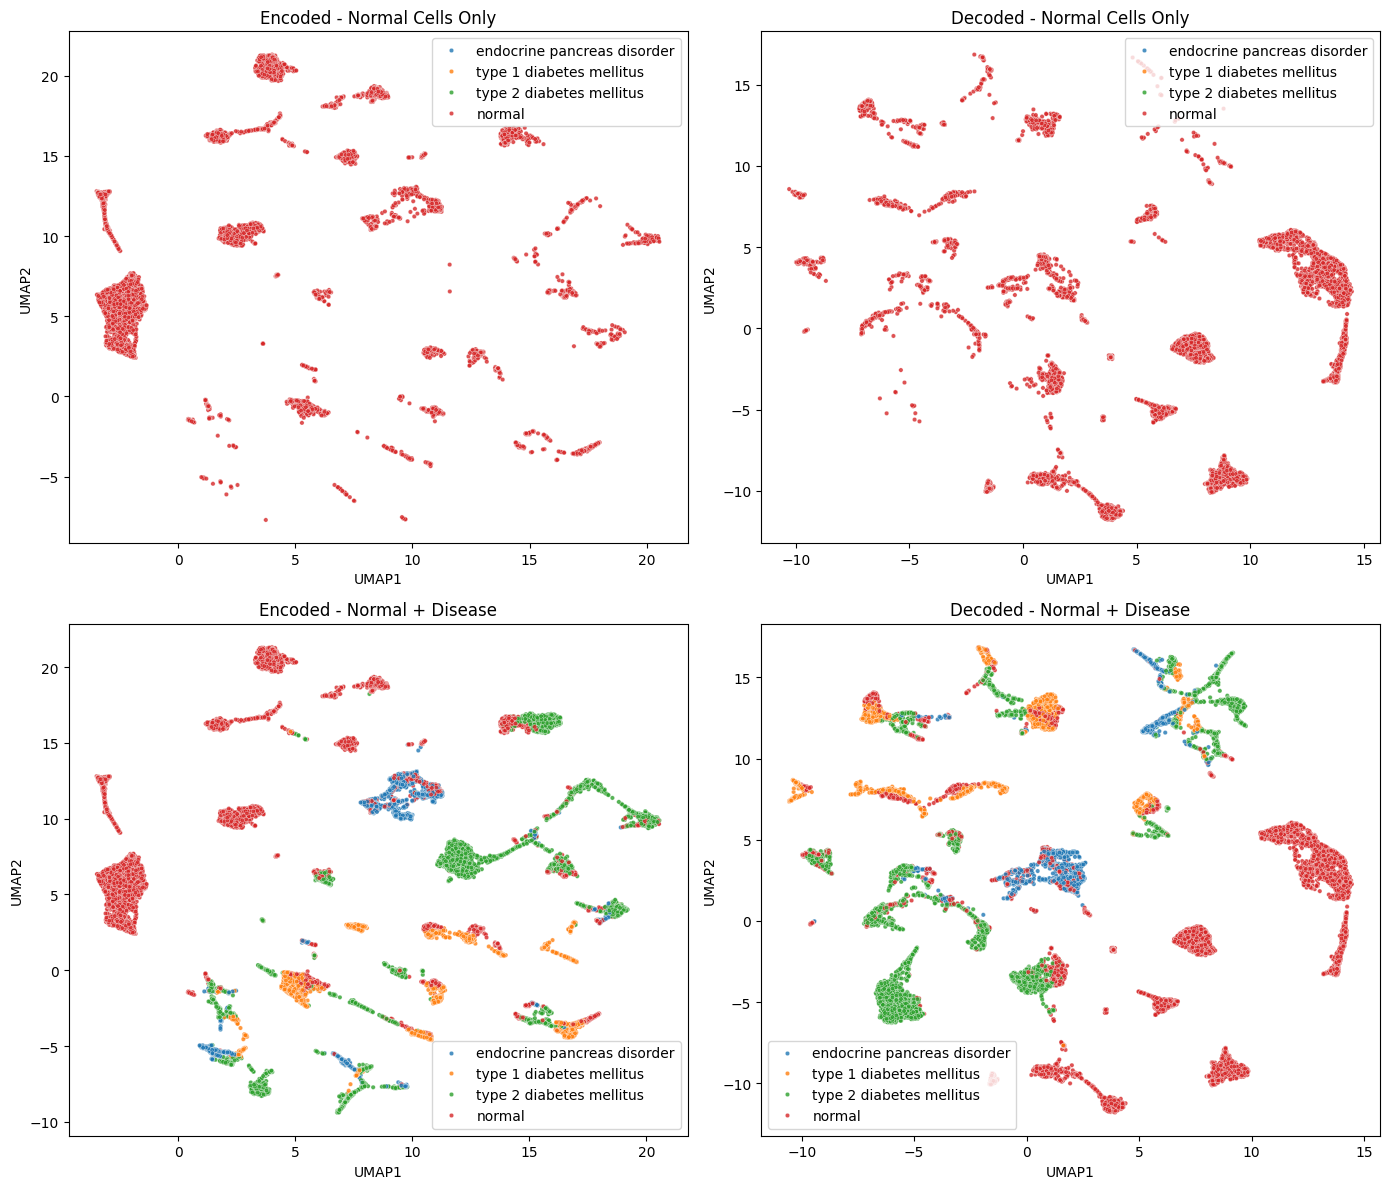

In [58]:
# === 1. Create masks and labels ===
normal_mask = test_data.obs["disease"] == "normal"
disease_labels = test_data.obs["disease"].values

# === 2. Predict encoded & decoded representations ===
X_encoded = encoder.predict(X_test, batch_size=64)
X_decoded = best_model.predict(X_test, batch_size=64)

# === 3. Run UMAP once per full dataset ===
umap_encoded = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_decoded = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)

X_umap_encoded_all = umap_encoded.fit_transform(X_encoded)
X_umap_decoded_all = umap_decoded.fit_transform(X_decoded)

# === 4. Create DataFrames ===
df_encoded_all = pd.DataFrame(X_umap_encoded_all, columns=["UMAP1", "UMAP2"])
df_encoded_all["disease"] = disease_labels

df_decoded_all = pd.DataFrame(X_umap_decoded_all, columns=["UMAP1", "UMAP2"])
df_decoded_all["disease"] = disease_labels

# Subset to normal only (just filter)
df_encoded_normal = df_encoded_all[df_encoded_all["disease"] == "normal"]
df_decoded_normal = df_decoded_all[df_decoded_all["disease"] == "normal"]

# === 5. Plot ===
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
axs = axs.flatten()

# Top row: only normal
sns.scatterplot(data=df_encoded_normal, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axs[0])
axs[0].set_title("Encoded - Normal Cells Only")
axs[0].legend(loc="best")

sns.scatterplot(data=df_decoded_normal, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axs[1])
axs[1].set_title("Decoded - Normal Cells Only")
axs[1].legend(loc="best")

# Bottom row: normal + disease
sns.scatterplot(data=df_encoded_all, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axs[2])
axs[2].set_title("Encoded - Normal + Disease")
axs[2].legend(loc="best")

sns.scatterplot(data=df_decoded_all, x="UMAP1", y="UMAP2", hue="disease", s=10, alpha=0.8, ax=axs[3])
axs[3].set_title("Decoded - Normal + Disease")
axs[3].legend(loc="best")

plt.tight_layout()
plt.show()
